# Loans
### _By: Ankur Patel_
---

### Introduction:

BIRCH, which stands for Balanced Iterative Reducing and Clustering, is an algorithm appropriate for large data sets. Here, we will classify loan applications as approved or not (the flag response variable), using the following
predictors: debt-to-income ratio, FICO score, and request amount. 



In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from termcolor import colored

import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading dataset
df = pd.read_csv("Loans")
df.head()

,Approval,Debt-to-Income Ratio,FICO Score,Request Amount,Interest
0,F,0.0,397,1000,450.0
1,F,0.0,403,500,225.0
2,F,0.0,408,1000,450.0
3,F,0.0,408,2000,900.0
4,F,0.0,411,5000,2250.0


In [3]:
# descriptive stats of dataset
df.describe()

,Debt-to-Income Ratio,FICO Score,Request Amount,Interest
count,150302.000000,150302.000000,150302.000000,150302.000000
mean,0.183538,672.023266,13427.080145,6042.186065
std,0.137226,69.129157,9468.345958,4260.755681
min,0.000000,371.000000,500.000000,225.000000
25%,0.090000,647.000000,6000.000000,2700.000000
50%,0.160000,684.000000,11000.000000,4950.000000
75%,0.240000,714.000000,19000.000000,8550.000000
max,1.030000,869.000000,44000.000000,19800.000000


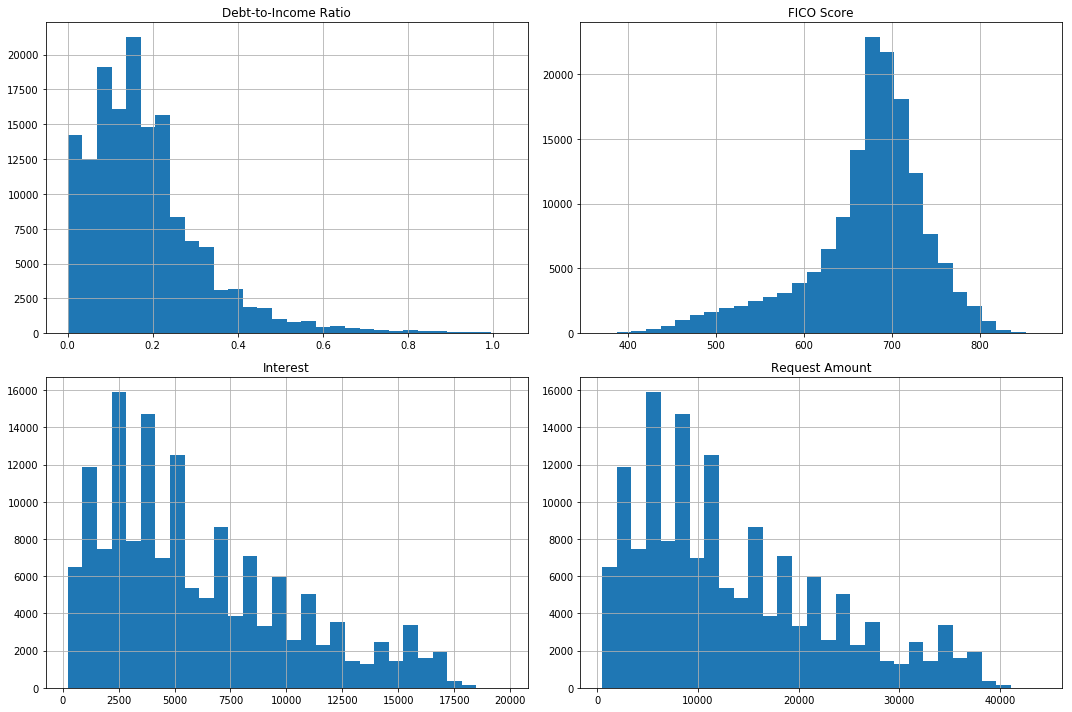

In [4]:
df.hist(bins=30, figsize=(15,10))
plt.tight_layout()    
plt.show()

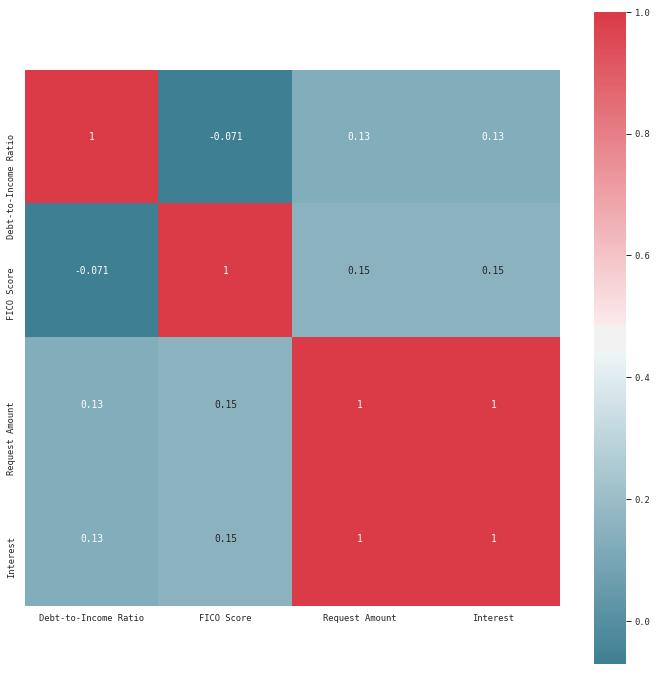

In [5]:
#continuous features correlation
sns.set(context="paper",font="monospace")
corr_matrix = df.corr()
fig, axe = plt.subplots(figsize=(12,12))
cmap = sns.diverging_palette(220,10,center = "light", as_cmap=True) #color palettes
sns.heatmap(corr_matrix,vmax=1,square =True, cmap=cmap,annot=True ) #draw heatmap

In [6]:
# The amount of interest is a mathematical function of the request amount, 
# and is perfectly correlated with that predictor, so will be excluded
df['Request Amount'].corr(df['Interest'])

1.0

In [7]:
# splitting into X and target y sets
X = df.iloc[:, 1:4]
y = df.loc[:, 'Approval']

In [8]:
print(X.head(2), "\n", type(X), "\n")
print(y.head(2), "\n", type(y))

   Debt-to-Income Ratio  FICO Score  Request Amount
0                   0.0         397            1000
1                   0.0         403             500 
 <class 'pandas.core.frame.DataFrame'> 

0    F
1    F
Name: Approval, dtype: object 
 <class 'pandas.core.series.Series'>


In [9]:
# splitting into train and test for two subsets of clusters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print("Train of", len(X_train), "; Test of", len(X_test))

Train of 112726 ; Test of 37576


In [10]:
# standardize to get same scaled variables since they are differently scaled
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### Review (1):
The Loans dataset was briefly viewed through descriptive stats, histograms, and correlation graph. The dataset was split into X of Debt-to-Income Ratio,  FICO Score, and  Request Amount, and Interest, and y of Approval. Since the EDA showed 1.0 correlation of Request Amount and Interest, Interest was excluded from the X set. After Standard scaling the X set, they were split along with y for the train test sets.

### BIRCH Clustering:

Parameters:
- Threshold - The radius of the subcluster obtained by merging a new sample and the closest subcluster should be lesser than the threshold.
- Branching_factor - Maximum number of CF subclusters in each node. If a new samples enters such that the number of subclusters exceed the branching_factor then that node is split into two nodes with the subclusters redistributed in each.
- N_clusters - Number of clusters after the final clustering step, which treats the subclusters from the leaves as new samples.

reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html

In [40]:
# define BIRCH clustering

def birch(threshold, n_clusters, branching_factor):
    
    # defining birch function
    brc = Birch(threshold=threshold, n_clusters=n_clusters, branching_factor=branching_factor, compute_labels=True)
    brc.fit(X_train_scaled)
    pred = brc.predict(X_train_scaled)
    pred = pd.DataFrame(pred, columns = ['Pred'])
    print("parameters: threshold=",threshold, ",  n_clusters=",n_clusters, ",  branching_factor=",branching_factor, "\n")
    print(pred['Pred'].value_counts())
    
    # predicting value counts of the clusters
    print("\nPredict of 0:", (pred['Pred'].value_counts()[0] / sum(pred['Pred'].value_counts()))*100, "%")
    print("Predict of 1:", (pred['Pred'].value_counts()[1] / sum(pred['Pred'].value_counts()))*100, "%")

    # plot the subclusters
    sc = brc.subcluster_centers_
    blue_patch = mpatches.Patch(color='blue', label='X')
    orange_patch = mpatches.Patch(color='orange', label='BRC')       
    plt.plot(X_train_scaled[:,0], X_train_scaled[:,1], '+')
    plt.plot(sc[:,0], sc[:,1], 'o')
    plt.legend(handles=[blue_patch, orange_patch])
    plt.show()

    # silhoutte scores using euclidean metrics
    ss = silhouette_score(X_train_scaled, pred, metric='euclidean', random_state=42)
    print("Silhouette score of train:", ss*100, "%")
    # test scores
    pred_test = brc.predict(X_test)
    pred_test = pd.DataFrame(pred_test, columns = ['Pred'])
    print(pred_test['Pred'].value_counts())
    ss_test = silhouette_score(X_test_scaled, pred_test, metric='euclidean', random_state=43)
    print("\nSilhouette score of test:", ss_test*100, "%")
    
    # visualize subcluster centers 
    print("Subcluster centers:")
    plt.scatter(sc[:, 0], sc[:, 1], marker='o', alpha=1, s=200, edgecolor='k')

parameters: threshold= 0.5 ,  n_clusters= 2 ,  branching_factor= 50 

0    110964
1      1762
Name: Pred, dtype: int64

Predict of 0: 98.43691783616912 %
Predict of 1: 1.5630821638308818 %


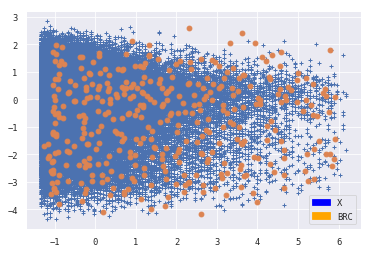

Silhouette score of train: 52.78769721179608 %
1    28237
0     9339
Name: Pred, dtype: int64

Silhouette score of test: 14.4376794678477 %
Subcluster centers:


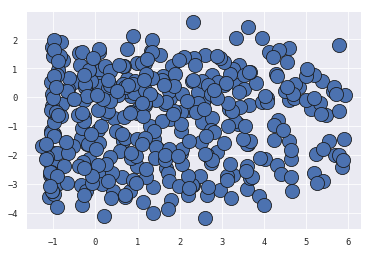

In [12]:
birch(threshold=0.5, n_clusters=2, branching_factor=50)

parameters: threshold= 0.5 ,  n_clusters= 3 ,  branching_factor= 100 

1    85724
2    23373
0     3629
Name: Pred, dtype: int64

Predict of 0: 3.219310540602878 %
Predict of 1: 76.04634245870517 %


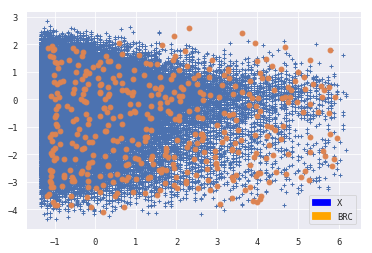

Silhouette score of train: 28.67509751851527 %
0    35145
1     2431
Name: Pred, dtype: int64

Silhouette score of test: 9.298788374242353 %
Subcluster centers:


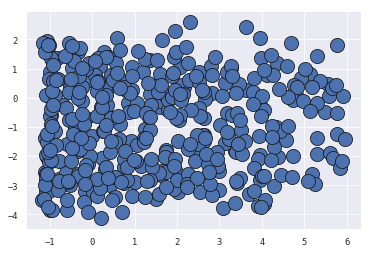

In [13]:
birch(threshold=0.5, n_clusters=3, branching_factor=100)

parameters: threshold= 0.2 ,  n_clusters= 2 ,  branching_factor= 50 

0    106437
1      6289
Name: Pred, dtype: int64

Predict of 0: 94.42098539822223 %
Predict of 1: 5.579014601777762 %


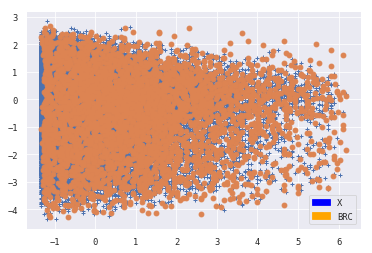

Silhouette score of train: 39.45945214172425 %
0    35921
1     1655
Name: Pred, dtype: int64

Silhouette score of test: 10.63694247833913 %
Subcluster centers:


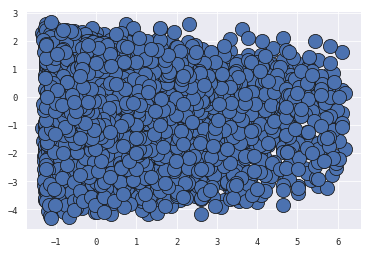

In [14]:
birch(threshold=0.2, n_clusters=2, branching_factor=50)

### Review (2):
The BIRCH clustering was performed with the following parameters to predict the cluster values, visualize the subcluster_centers, and get a silhouette score of the train first then the test: 
- threshold=0.5, n_clusters=2, branching_factor=50  
- threshold=0.5, n_clusters=3, branching_factor=100  
- threshold=0.2, n_clusters=2, branching_factor=50  

The silhouette scores from BIRCH clustering were, respectively,:
- train: 52.8%, test: 14.4%
- train: 28.6%, test: 9.3%
- train: 39.4%, test: 10.6%

### KMeans Silhouette Analysis:

Silhouette analysis on KMeans clustering was also performed to compare the clustering with BIRCH. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.

In [29]:
# define KMeans Silhouette Analysis with input of X set

def kmeans_silh(X):
    
    range_n_clusters = [2,3]
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=0)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.6374999684422217
For n_clusters = 3 The average silhouette_score is : 0.579207733320697


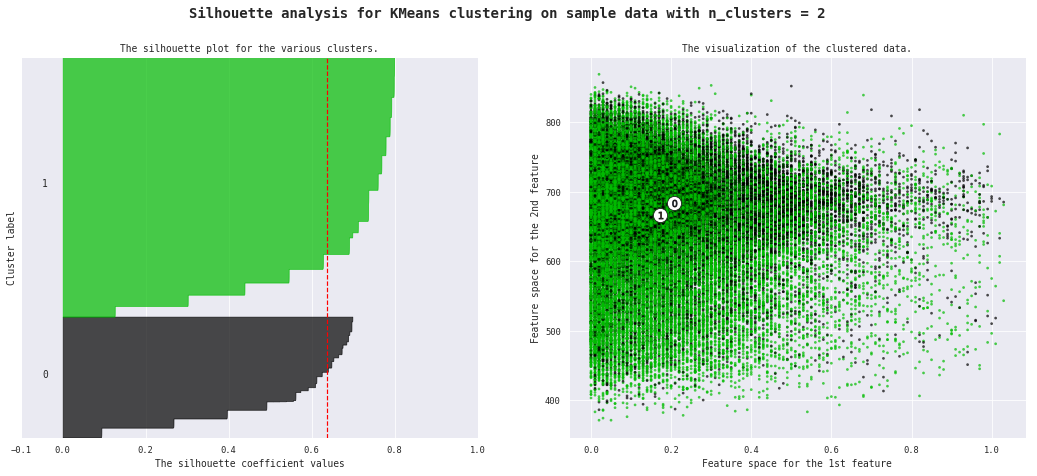

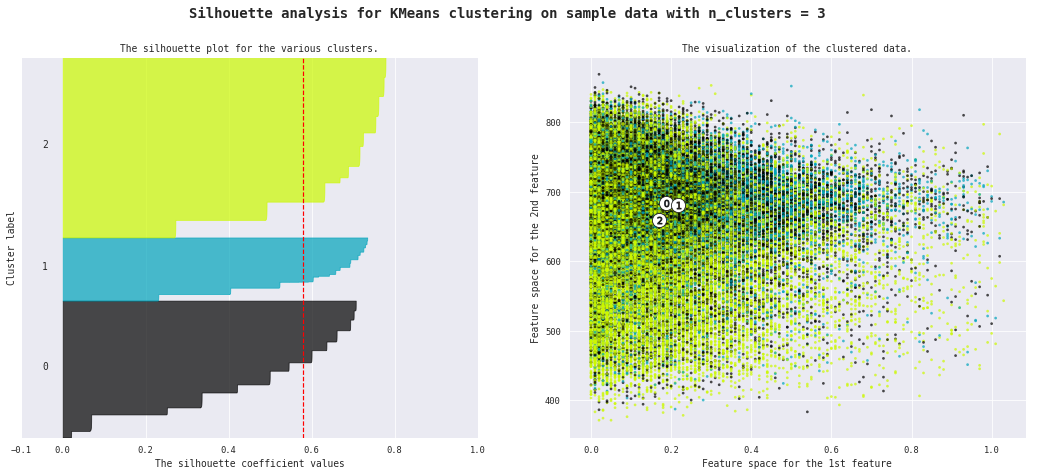

In [32]:
# Unscaled X_train
kmeans_silh(X=X_train.values)

For n_clusters = 2 The average silhouette_score is : 0.2912308721791923
For n_clusters = 3 The average silhouette_score is : 0.31843999451445654


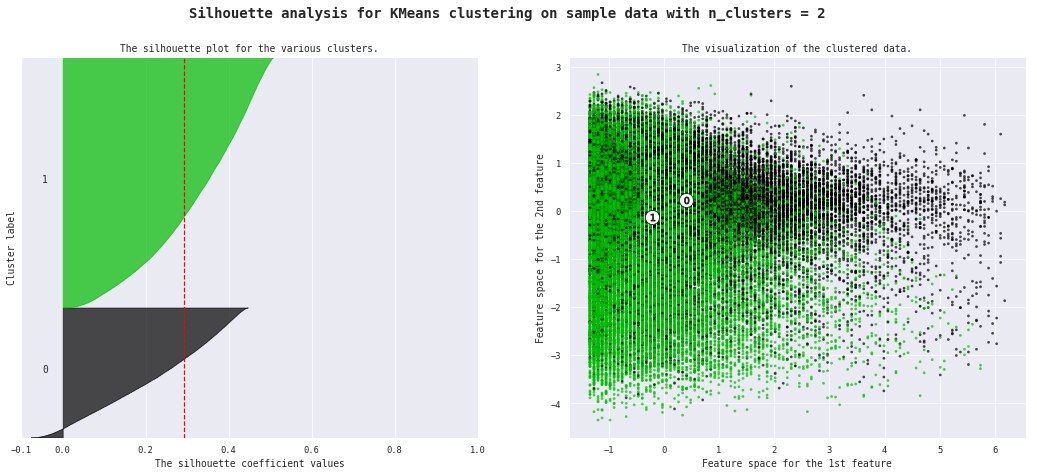

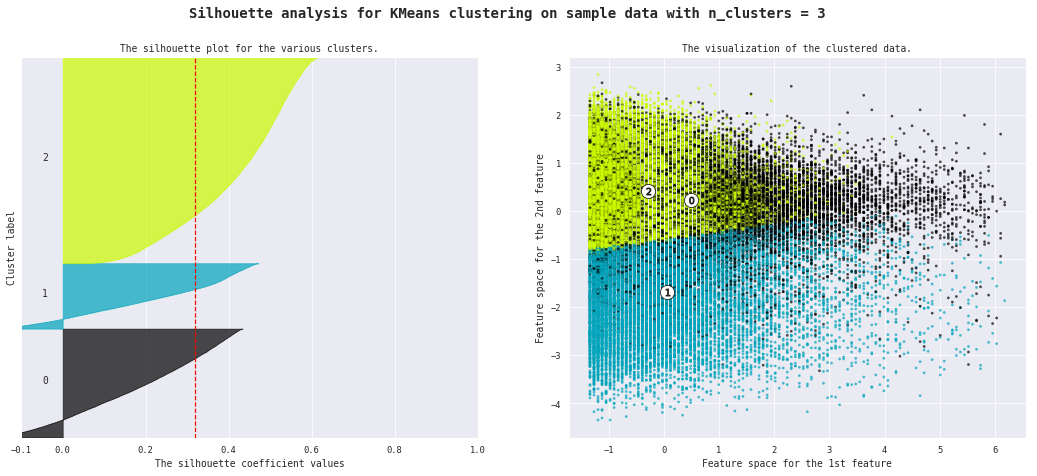

In [35]:
# Scaled X_train_scaled
kmeans_silh(X=X_train_scaled[:,:])

For n_clusters = 2 The average silhouette_score is : 0.6374662044968662
For n_clusters = 3 The average silhouette_score is : 0.5847775058414069


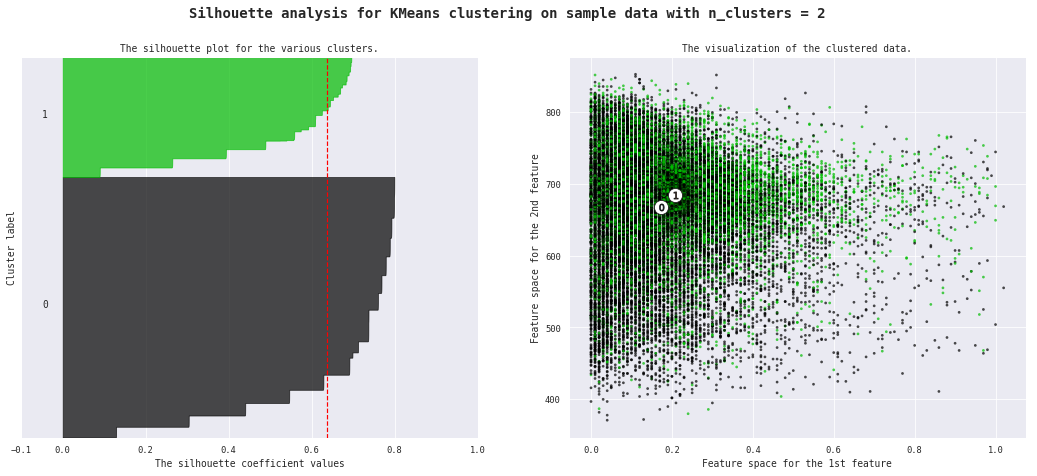

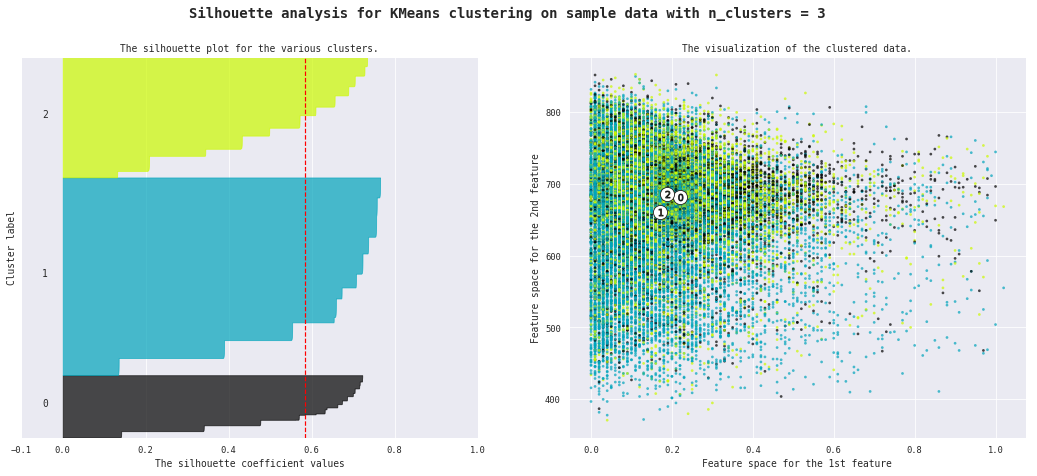

In [38]:
# Unscaled X_test
kmeans_silh(X=X_test.values)

For n_clusters = 2 The average silhouette_score is : 0.2930977366906526
For n_clusters = 3 The average silhouette_score is : 0.31760960283203876


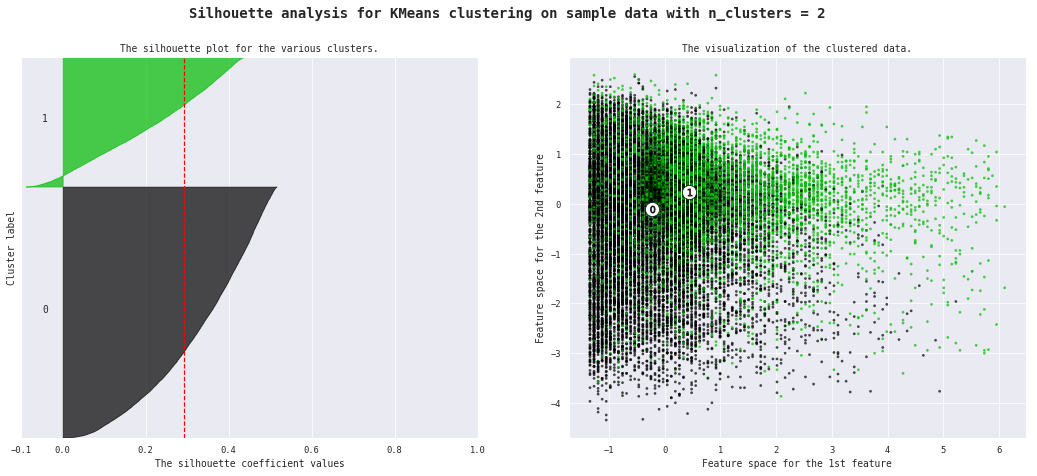

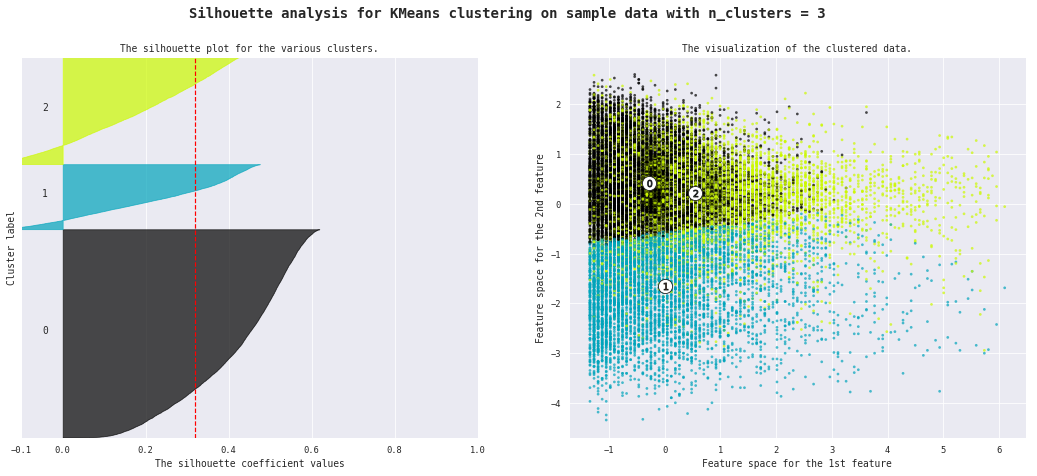

In [37]:
# Scaled X_test
kmeans_silh(X=X_test_scaled[:,:])

### Review (3):
KMeans clustering was also performed for a silhouette score and graphs. The defined function for Kmeans Silhouette Analysis was tested with unscaled X_train, scaled X_train, unscaled X_test, and scaled X_test. The unscaled gave a better scores and cluster visuals, although the variables were significantly different.

Here are the scores for the different X sets:  
- Unscaled X_train:
    - n_clusters = 2, silhouette_score is : 0.6375
    - n_clusters = 3, silhouette_score is : 0.5792
- Scaled X_train:
    - n_clusters = 2, silhouette_score is : 0.2912
    - n_clusters = 3, silhouette_score is : 0.3184
- Unscaled X_test:
    - n_clusters = 2, silhouette_score is : 0.6374
    - n_clusters = 3, silhouette_score is : 0.5847
- Scaled X_test:
    - n_clusters = 2, silhouette_score is : 0.2930
    - n_clusters = 3, silhouette_score is : 0.3176

### Conclusion:
Using BIRCH clustering, the train and test silhouette scores differed significantly. After tuning the parameters, the best one with a silhoutte score of 52.8% with train set, while a 14.4% with test set. 

The Silhouette Score from KMeans resulted in better scores than BIRCH, in terms of __stability__. Both train and test scores were similar, as opposed to BIRCH clustering which resulted in extremely different scores.